In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
from functions.indicators import indicator
from sklearn.metrics import mean_squared_error as mse
from functions.models import mode_0, mode_1, mode_2, mode_3, mode_4, mode_5, mode_6
from functions.comparison import gaussian_closedform, gaussian_gradientdescent, poly_ERM,kernelregression_closedform
from functions.createdata import CreateData
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size':15}) 

# Data generation

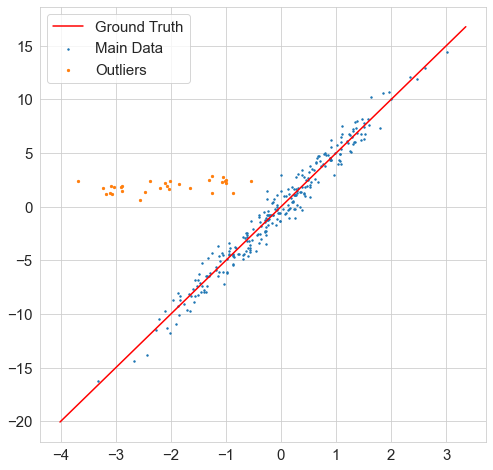

In [2]:
X, y, Xtst, ytst = CreateData(1,'gaussian') # dimension = 1

# ERM

training set
 max loss: 165.3617967028134, min loss: 0.0006487974252443439, avg loss: 11.911583894681028, variance: 516.4896397285517
test set
max loss: 64.99690353716406, min loss: 0.0003397809780643669, avg loss: 5.532642016806808, variance: 60.463835300510546


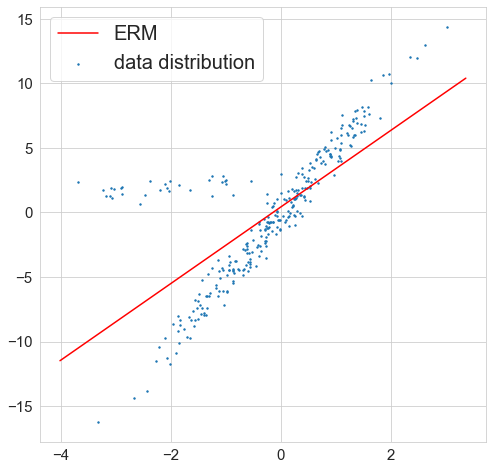

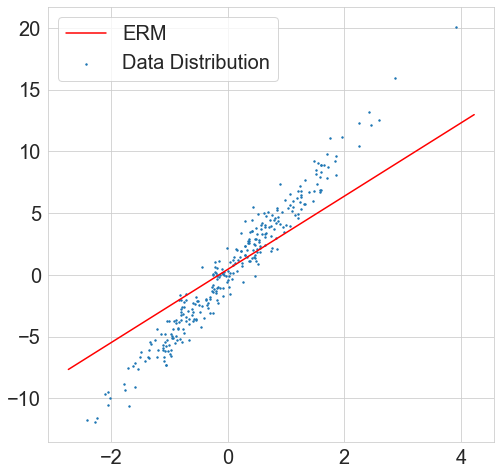

In [3]:
mode_0(X, y, Xtst, ytst,iters=500,learning_step=0.002,tol = 1/10**8,losstype='mse',h=1,delta=2,online = False)

# EDRM variable e = y-f(x)

Iterations 0 Training Errors 25.94783617442615 test_R2 0.014410681359947941
Iterations 1 Training Errors 25.45675629362248 test_R2 0.036037063121883484
Iterations 2 Training Errors 24.969131429000473 test_R2 0.05763488144569873
Iterations 3 Training Errors 24.48169811262971 test_R2 0.07934456004868229
Iterations 4 Training Errors 23.991492351573232 test_R2 0.10129874238514092
Iterations 5 Training Errors 23.496264921682442 test_R2 0.12360409429613317
Iterations 6 Training Errors 22.994986246435953 test_R2 0.14631832249222443
Iterations 7 Training Errors 22.48834265716797 test_R2 0.1694263029852503
Iterations 8 Training Errors 21.979041410300365 test_R2 0.19282325276718126
Iterations 9 Training Errors 21.471704791471684 test_R2 0.216315234478194
Iterations 10 Training Errors 20.97219456392447 test_R2 0.239645346219157
Iterations 11 Training Errors 20.48641730827802 test_R2 0.26254489730066777
Iterations 12 Training Errors 20.019023877201157 test_R2 0.28479209690717466
Iterations 13 Trai

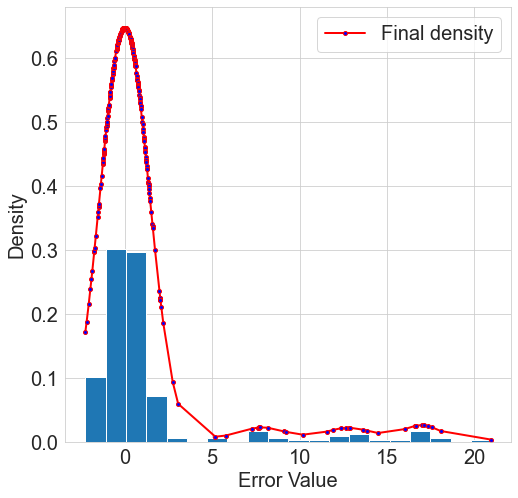

training set
ρ>1, max loss: 439.24109267324104, min loss: 3.694024536359029e-06, avg loss: 18.272724705458625, variance: 3851.428899566163
test set
ρ>1, max loss: 11.375586282269207, min loss: 8.56803884626308e-05, avg loss: 1.10520526028102, variance: 2.45087368221603
The linear weight:  5.037018843355864 the constrant: -0.06679505089073798


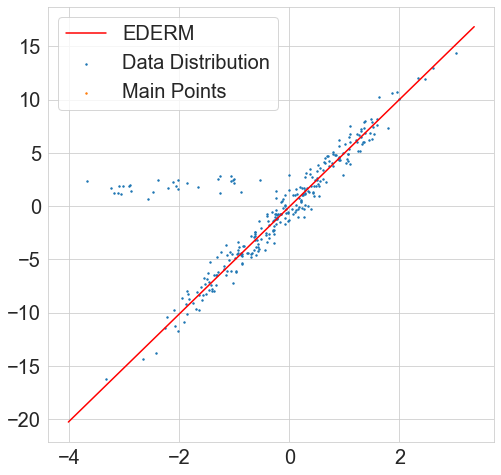

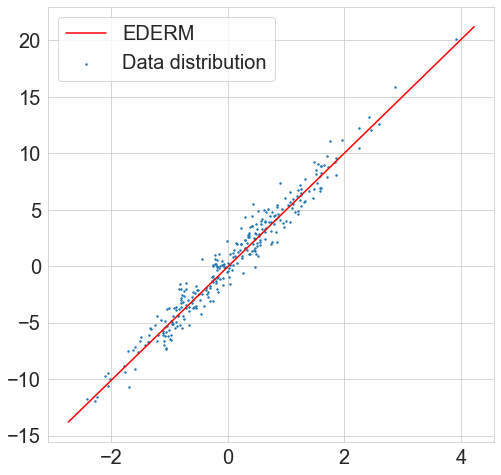

In [4]:
mode_1(X, y, Xtst, ytst,iters=200,lamb=1,learning_step=0.002,tol = 1/10**8,Ictype='correntropy',losstype='mse',h=1,delta=2,online =True)

In [5]:
def abline(a,  label_, c=None ):
    axes       = plt.gca()
    x_vals     = np.array(axes.get_xlim())
    x_vals     = x_vals.reshape((x_vals.shape[0], 1))
    intercept  = np.ones((x_vals.shape[0], 1))
    x_vals     = np.concatenate((x_vals, intercept), axis=1) 
    y_vals     = np.dot(x_vals , a)
    plt.plot(x_vals[:,0:-1], y_vals, label=label_, color=None)

In [6]:
def kerneldensity(loss,fai): 
    '''
        loss:   y-y_pred  
    '''
    lossinds    = loss.argsort()
    sorted_loss = loss[lossinds[:]]
    x2          = sorted_loss
    y2          = fai[lossinds[:]]   # final ρ
    plt.figure(figsize=(8, 8))
    plt.plot(x2,y2,label='Final density',linewidth=2,color='r',marker='o', markerfacecolor='blue',markersize=4)
    plt.hist(loss, bins = 20,density = True)
    plt.grid(True) 
    plt.xlabel('Error Value') 
    plt.ylabel('Density') 
    # plt.title('The final error density',fontsize= 'xx-large') 
    plt.legend() 
    plt.show()

# EDERM variable e^2 = (y-f(x))^2

In [7]:
def Square_EDERM(X, y, Xtst, ytst,iters,lamb,learning_step,tol,Ictype,h,delta,online,flag='LS'):
    '''
        correntropy-Induced approximated Indicator single mode
        linear regression y = x*w + b
        λ<ρ restrict the indicator function I  = I(ρ>λ)
        We have the following
            F = sum(f(zi) * I)/n = sum(f(zi) * I(ρ>λ))/n 
           dF = sum(df*I + f*dI )/n 
    '''
    #init params
    intercept  = np.ones((X.shape[0], 1))
    X_         = np.concatenate((X, intercept), axis=1)
    intercept  = np.ones((Xtst.shape[0], 1))
    Xtst_      = np.concatenate((Xtst, intercept), axis=1)
    n          = X_.shape[0]
    features   = X_.shape[1]
    theta_hat  = np.zeros(features)
    for k in range(iters):
        Ic     =  np.zeros(n)
        R      =  np.zeros(iters)
        mainx  =  []  #save important points
        mainy  =  []
        grad   =  np.zeros(features)
        fai    =  np.zeros(n) #final error density
        #下面是用来求I的导数的
        dfai   =  np.zeros([n,features])
        loss   =  np.zeros(n)
        dloss  =  np.zeros([n,features])
        Ic     =  np.zeros(n)
        Points =  np.zeros(n)
        dIc    =  np.zeros([n,features])
        y_pred =  np.dot(X_, theta_hat)
        error  =  (y-y_pred) 
        errors =  (y-y_pred)* (y-y_pred) 
        olderr = mse(y,y_pred)
        for i in range(0,n):
            for j in range(0,n):
                fai[i]  = fai[i]  + (1/(n*h))* math.exp((errors[i]-errors[j])**2/(-2*h*h))
                dfai[i] = dfai[i] + (1/(n*h))* math.exp((errors[i]-errors[j])**2/(-2*h*h)) \
                    * ((errors[i]-errors[j])/(h*h)) *2*error[i]*(X_[i].T)
            loss[i] = error[i]**2
            dloss[i]= (2*X_[i].T*(y_pred[i]-y[i]))
            Ic[i],dIc[i]     = indicator(Ictype, fai[i], dfai[i], lamb,delta)
            R[k]    +=  errors[i]*Ic[i]
            grad    +=  dloss[i]*Ic[i]+loss[i]*dIc[i] 
        theta_hat = theta_hat - learning_step * grad 
        newerr = mse(y,np.dot(X_, theta_hat))
        if(online == True):
            print("iterations",k,"Errors",newerr)
        if(abs(newerr - olderr) < tol):
            break
    #show density info
    kerneldensity(errors,fai)
    
    print("training set")
    y_pred = np.dot(X_, theta_hat)
    loss = (y-y_pred)* (y-y_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))

    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(X, y, s=2, label='Data Distribution')
        if(flag=='LS'):
            plt.scatter(mainx, mainy, s=2)
            abline(theta_hat,  'EDERM')
        else:
            abline(theta_hat,  'Correntropy')
        plt.grid(True)
        plt.legend()

    print("test set")    
    ytst_pred = np.dot(Xtst_,theta_hat)
    loss = (ytst-ytst_pred)* (ytst-ytst_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))

    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(Xtst, ytst, s=2, label='Data distribution')
        if(flag=='LS'):
            abline(theta_hat,  'EDERM')
        else:
            abline(theta_hat,  'Correntropy')
        plt.grid(True) 
        plt.legend()
    print("The linear weight: ",theta_hat[-2],"the constrant:",theta_hat[-1])

iterations 0 Errors 25.639338433751007
iterations 1 Errors 24.8462000649214
iterations 2 Errors 24.077753659741273
iterations 3 Errors 23.351574440548738
iterations 4 Errors 22.6059973667945
iterations 5 Errors 21.880560703859047
iterations 6 Errors 21.100226854426364
iterations 7 Errors 20.52787158932084
iterations 8 Errors 19.697801219861443
iterations 9 Errors 19.152043518754233
iterations 10 Errors 18.57980309353467
iterations 11 Errors 18.107604079197507
iterations 12 Errors 17.60408836239357
iterations 13 Errors 17.044043949073803
iterations 14 Errors 16.63460635751654
iterations 15 Errors 16.189294076967634
iterations 16 Errors 15.674984189179831
iterations 17 Errors 15.422679827981998
iterations 18 Errors 15.010781168385572
iterations 19 Errors 14.552672539804705
iterations 20 Errors 14.216608607856251
iterations 21 Errors 13.873273213496661
iterations 22 Errors 13.582929471357163
iterations 23 Errors 13.342034389153914
iterations 24 Errors 13.085564262555872
iterations 25 Erro

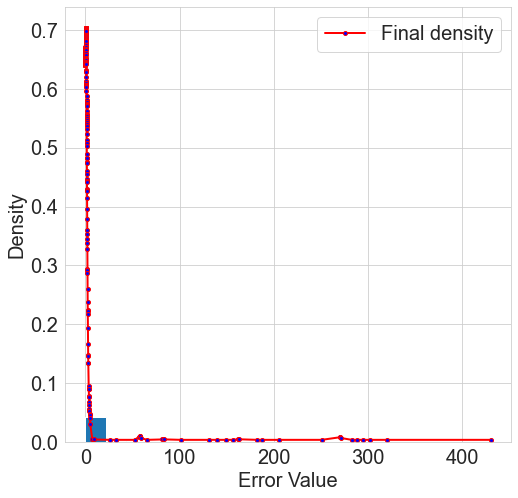

training set
ρ>0.89, max loss: 430.89001022432967, min loss: 1.7517904305194003e-06, avg loss: 17.92939504460904, variance: 3700.4151298755323
test set
ρ>0.89, max loss: 11.351072468550646, min loss: 3.961069728444798e-05, avg loss: 1.1014081210829745, variance: 2.436656458721393
The linear weight:  4.989225145853579 the constrant: -0.04233982455900656


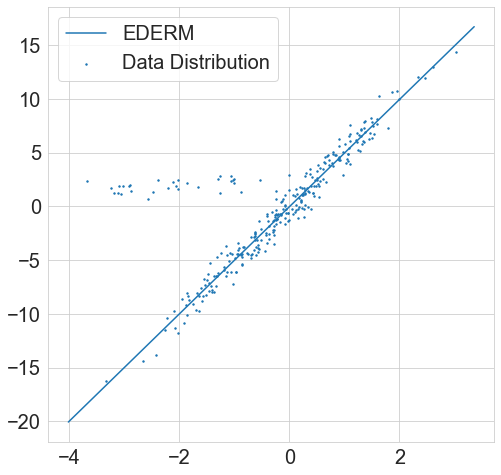

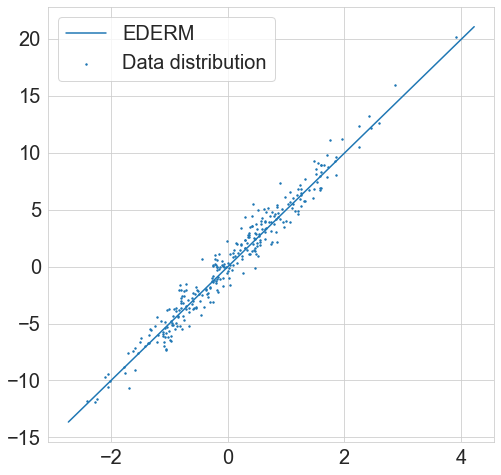

In [8]:
Square_EDERM(X, y, Xtst, ytst,iters=300,lamb=0.89,learning_step=0.002,tol = 1/10**12,Ictype='correntropy',h=1,delta=2,online =True)